# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1]:
# conda install -c conda-forge gensim

In [2]:
import os
import time
import pandas as pd
import numpy as np
import re
import nltk
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt

In [3]:
DATA_FILE = 'lyrics.csv'
DATA_DIR = 'data'
MODELS_DIR = 'models'

SKIPGRAM = 1
NUM_WORKERS = 12

TO_RUN = True

In [4]:
%%time

path = os.path.join(DATA_DIR, DATA_FILE)

# read and keep only necessary columns
df = pd.read_csv(path, index_col='index', usecols=['index', 'genre', 'lyrics'])

print(f'data shape: {df.shape}')
print(f'columns names: {df.columns.values}')

df.head()

data shape: (362237, 2)
columns names: ['genre' 'lyrics']
CPU times: user 1.86 s, sys: 144 ms, total: 2.01 s
Wall time: 2.01 s


,genre,lyrics
index,,
0,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,Pop,"playin' everything so easy,\nit's like you see..."
2,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,Pop,"Party the people, the people the party it's po..."


There are songs without lyrics provided 

In [5]:
df.isnull().sum()

genre         0
lyrics    95680
dtype: int64

so we'll remove them

In [6]:
df.dropna(inplace=True)
df.shape

(266557, 2)

We'll preprocess the lyrics as requested.  
In addition, we'll also remove all non-alpha-bet characters and single letters.

In [7]:
stops = set(nltk.corpus.stopwords.words("english"))  # define set of stopwords

def preprocess(raw_lyrics, stopwords=stops):
    
    # remove all non-alphabet characters
    words = re.sub("[^a-zA-Z]", " ", raw_lyrics)  
    #lowercase and tokenize words
    words = words.lower().split()  
    # remove stopwords and single characters
    words = [w for w in words if w not in stopwords if len(w) > 1]  
    
    return words

In [8]:
def print_time(t0, t1, to_print=True):
    """Helper function to track execution timing"""
    
    dt = t1 - t0
    hours = dt // 3600 % 24
    minutes = dt // 60 % 60
    seconds = dt % 60
    
    s = (f'{int(hours):02}:{int(minutes):02}:{seconds:06.3f}')
    
    if to_print:
        print(s)
    else:
        return s   

class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""
    
    def __init__(self):
        self.epoch = None
        self.t_train = None
        
    def on_train_begin(self, model):
        print('begin training')
        self.epoch = 1
        self.t_train = time.time()
    
    def on_train_end(self, model):
        print('\ntotal time:', self._print_time(self.t_train, time.time()))
    
    def on_epoch_begin(self, model):
        self.t_epoch = time.time()
        
    def on_epoch_end(self, model):
        print(f'Epoch #{self.epoch} ended;', self._print_time(self.t_epoch, time.time()))
        self.epoch += 1
    
    @staticmethod
    def _print_time(t0, t1):
        return print_time(t0, t1, to_print=False)

### First, we start small..
to see that everything works

In [9]:
mini_df = df.sample(n=100, random_state=42)
mini_df['clean_lyrics'] = mini_df.lyrics.apply(preprocess)  

In [10]:
%%time
num_features = 16    # Word vector dimensionality                      
context = 3         # Context window size  
min_word_count = 2   # Minimum word count
epochs = 3          # Number of iter

w2v_mini = Word2Vec(mini_df.clean_lyrics,
                    iter=epochs,
                    sg=SKIPGRAM, 
                    min_count=min_word_count, 
                    size=num_features, 
                    window=context, 
                    workers=NUM_WORKERS, 
                    callbacks=[EpochLogger()])


begin training
Epoch #1 ended; 00:00:00.020
Epoch #2 ended; 00:00:00.020
Epoch #3 ended; 00:00:00.019

total time: 00:00:00.060
CPU times: user 300 ms, sys: 8.44 ms, total: 308 ms
Wall time: 288 ms


In [11]:
w2v_mini.wv.most_similar([w2v_mini.wv['young'] + w2v_mini.wv['boy']], topn=5) 

[('go', 0.978050947189331),
 ('thing', 0.9779292345046997),
 ('away', 0.9771550893783569),
 ('times', 0.9770342111587524),
 ('girl', 0.9770339727401733)]

### The real deal

We'll process the lyrics, and remove "songs" that are 1-2 words long.

In [12]:
%%time
if TO_RUN:
    t = time.time()
    df['clean_lyrics'] = df.lyrics.apply(preprocess)  
    
    df['n_words'] = df.clean_lyrics.apply(len)
    df = df.drop(df[df['n_words'] < 3 ].index).drop(labels='n_words', axis=1)
    
    df.to_pickle(os.path.join(DATA_DIR, 'lyrics_df.pkl'))
    
    print(f'total time to run: {print_time(t, time.time())}')

00:00:33.699
total time to run: None
CPU times: user 30.4 s, sys: 1.66 s, total: 32.1 s
Wall time: 33.7 s


In [13]:
%%time
df = pd.read_pickle(os.path.join(DATA_DIR, 'lyrics_df.pkl'))
df.shape

CPU times: user 4.17 s, sys: 719 ms, total: 4.89 s
Wall time: 4.88 s


(260949, 3)

In [14]:
%%time

num_features = 300     # Word vector dimensionality                      
context = 7           # Context window size  
min_word_count = 200   # Minimum word count
epochs = 10            # Number of iter

if TO_RUN:
    w2v = Word2Vec(df.clean_lyrics,
                   iter=epochs,
                   sg=SKIPGRAM, 
                   min_count=min_word_count, 
                   size=num_features, 
                   window=context, 
                   workers=NUM_WORKERS, 
                   callbacks=[EpochLogger()])
    
    # save the model  
    w2v.save(os.path.join(MODELS_DIR, f'w2v.model'))


begin training
Epoch #1 ended; 00:00:54.261
Epoch #2 ended; 00:00:55.695
Epoch #3 ended; 00:00:56.962
Epoch #4 ended; 00:00:56.860
Epoch #5 ended; 00:00:57.978
Epoch #6 ended; 00:00:58.026
Epoch #7 ended; 00:00:58.766
Epoch #8 ended; 00:00:57.990
Epoch #9 ended; 00:00:59.292
Epoch #10 ended; 00:00:59.368

total time: 00:09:35.199
CPU times: user 1h 50min 14s, sys: 4.12 s, total: 1h 50min 18s
Wall time: 9min 41s


In [15]:
w2v = Word2Vec.load(os.path.join(MODELS_DIR, 'w2v.model'))

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

gensim uses the cosine similarity.  
We'll implement our version of euclidean similarity (not distance) in which 1.0 is the most similiar.

In [16]:
from scipy.spatial.distance import cdist

def euclidean_similarity(word, word2vec, topn=10, compare_to_known=True):
    
    v = word2vec.wv[word] if type(word) is str else word
    X = word2vec.wv.vectors
    
    scores = 1 - cdist(v[np.newaxis, :], X, metric='euclidean')
    
    if compare_to_known:
        indices = np.argsort(scores)[0, -topn-1:-1][::-1]
    else:
        indices = np.argsort(scores)[0, -topn:][::-1]

    words = np.asarray(word2vec.wv.index2entity)[indices]
    scores = scores[0, indices]
    
    return list(zip(words, scores))

In [17]:
w2v.wv.most_similar("freedom", topn=5)  # cosine similarity

[('liberty', 0.5238856673240662),
 ('free', 0.5001068115234375),
 ('redemption', 0.489173948764801),
 ('democracy', 0.44242534041404724),
 ('slavery', 0.42559778690338135)]

In [18]:
euclidean_similarity('freedom', w2v, topn=5)  # euclidean similarity

[('free', -1.8924694845136747),
 ('well', -2.2067390283281836),
 ('cause', -2.2170031056508583),
 ('life', -2.245122544410143),
 ('hear', -2.2468946605139397)]

In [19]:
w2v.wv.most_similar("young", topn=5)

[('younger', 0.44046443700790405),
 ('old', 0.4196534752845764),
 ('reckless', 0.4113911986351013),
 ('named', 0.39414143562316895),
 ('rich', 0.3934105634689331)]

In [20]:
euclidean_similarity('young', w2v, topn=5)

[('cause', -1.671198703427244),
 ('know', -1.749617003892324),
 ('like', -1.7827121470518783),
 ('never', -1.8356341304489514),
 ('old', -1.8377223124661302)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [21]:
v = w2v.wv['flower'] + w2v.wv['shone'] - w2v.wv['sun']
w2v.wv.similar_by_vector(v, topn=5)

[('flower', 0.7052069902420044),
 ('shone', 0.6851103901863098),
 ('flowers', 0.4319039583206177),
 ('rose', 0.410630464553833),
 ('blooming', 0.4004417359828949)]

In [22]:
euclidean_similarity(v, w2v, compare_to_known=False, topn=5)

[('flower', -3.032526982686286),
 ('shone', -3.1380384389585414),
 ('flowers', -4.203365000042902),
 ('rose', -4.318425917051742),
 ('seemed', -4.412854073839578)]

In [23]:
w2v.wv.most_similar(positive=['flower', 'shone'], negative=['sun'], topn=5)

[('flowers', 0.37676554918289185),
 ('rose', 0.3652315139770508),
 ('bouquet', 0.3322224020957947),
 ('blooming', 0.3312700390815735),
 ('blooms', 0.3270376920700073)]

In [24]:
w2v.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)

[('queen', 0.47604799270629883),
 ('kings', 0.4159427583217621),
 ('newborn', 0.37534332275390625),
 ('throne', 0.366534948348999),
 ('princess', 0.3480781316757202)]

In [25]:
v = w2v.wv['king'] + w2v.wv['woman'] - w2v.wv['man']
w2v.wv.similar_by_vector(v)

[('king', 0.7577380537986755),
 ('woman', 0.5558309555053711),
 ('queen', 0.5185304880142212),
 ('kings', 0.45267215371131897),
 ('throne', 0.4027484655380249),
 ('newborn', 0.3904724717140198),
 ('crown', 0.38474464416503906),
 ('princess', 0.3677555322647095),
 ('born', 0.36352550983428955),
 ('kong', 0.36222705245018005)]

In [26]:
# from scipy.spatial.distance import cosine, euclidean

# def my_cosine(v, u):
#     return np.dot(v, u) / (np.linalg.norm(v) * np.linalg.norm(u))

# def my_euclidean(v, u):
#     return 1 - np.linalg.norm(v - u)

# X = w2v.wv.vectors

# v1 = w2v.wv['freedom']
# v2 = w2v.wv['free']
# v3 = w2v.wv['liberty']
# v4 = w2v.wv['freedoms']

# print('cosine: \n')
# print(my_cosine(v, v1), 1 - cosine(v, v1))
# print(my_cosine(v, v2), 1 - cosine(v, v2))
# print(my_cosine(v, v3), 1 - cosine(v, v3))
# print(my_cosine(v, v4), 1 - cosine(v, v4))
# print()
# dist = 1 - cdist(v[np.newaxis, :], X, metric='cosine')
# print(np.sort(dist)[0, -7:][::-1])
# indices = np.argsort(dist)[0, -7:][::-1]
# print(indices)
# print()
# print(np.asarray(w2v.wv.index2entity)[indices])

# print('\neuclidean: \n')
# print(my_euclidean(v, v1), 1 - euclidean(v, v1))
# print(my_euclidean(v, v2), 1 - euclidean(v, v2))
# print(my_euclidean(v, v3), 1 - euclidean(v, v3))
# print(my_euclidean(v, v4), 1 - euclidean(v, v4))
# print()
# dist = 1 - cdist(v1[np.newaxis, :], X, metric='euclidean')
# print(np.sort(dist)[0, -7:][::-1])
# indices = np.argsort(dist)[0, -7:][::-1]
# print(indices)
# print()
# print(np.asarray(w2v.wv.index2entity)[indices])


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [27]:
lexicon = pd.read_csv(os.path.join(DATA_DIR, 
                                   'SemEval2015-English-Twitter-Lexicon', 
                                   'SemEval2015-English-Twitter-Lexicon.txt'), 
                             sep='\t', index_col=1, names=['sentiment'])
print(lexicon.head(), '\n')
print(lexicon.tail(), '\n')
print(lexicon.shape, '\n')
print(lexicon.isnull().sum(axis=0))


                sentiment
loves               0.984
#inspirational      0.984
amazing             0.969
#peaceful           0.969
#greatness          0.953 

                 sentiment
abuse               -0.969
#failure            -0.969
kill                -0.982
bitches             -0.984
#disappointment     -0.984 

(1515, 1) 

sentiment    0
dtype: int64


There are duplicate words in the 'SemEval2015-English-Twitter-Lexicon' after removing the #

In [28]:
lexicon.index = lexicon.index.str.replace('#', '')
np.sum(lexicon.index.value_counts() > 1)

83

so we'll take the mean of each of this duplicates as the sentiment valaue

In [29]:
lexicon = lexicon.groupby(lexicon.index).mean()
lexicon

,sentiment
&lt;3,0.531
&lt;33,0.625
(:,0.406
):,-0.297
-.-,0.089
...,...
yumm,0.516
yummm,0.813
yummy,0.703
yummyy,0.797


Taking only the words that apear in both datasets

In [30]:
data = lexicon.join(pd.DataFrame(index=w2v.wv.index2entity, data=w2v.wv.vectors), 
                    how='inner')
data.shape

(712, 301)

In [31]:
np.random.seed(42)

mask = np.random.rand(len(data)) < .85

train = data[mask]
test = data[~mask]

y_train = train.sentiment
y_test = test.sentiment

X_train = train.drop('sentiment', axis=1)
X_test = test.drop('sentiment', axis=1)

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [33]:
%%time

forest = RandomForestRegressor(max_depth=5).fit(X_train, y_train)
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

0.6927992500077531
0.24978047502926015
CPU times: user 3.91 s, sys: 11.9 ms, total: 3.92 s
Wall time: 3.38 s


In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
%%time

lin_reg = LinearRegression().fit(X_train, y_train)
print(lin_reg.score(X_train, y_train))
print(lin_reg.score(X_test, y_test))

0.8293189175978333
0.3555224825886837
CPU times: user 68.9 ms, sys: 18 µs, total: 68.9 ms
Wall time: 12.8 ms


In [36]:
%%time

ridge_reg = Ridge(alpha=500).fit(X_train, y_train)
print(ridge_reg.score(X_train, y_train))
print(ridge_reg.score(X_test, y_test))

0.7395804971984238
0.5412081617341606
CPU times: user 28.5 ms, sys: 0 ns, total: 28.5 ms
Wall time: 4.68 ms


In [37]:
%%time

lasso_reg = Lasso(alpha=.005).fit(X_train, y_train)
print(lasso_reg.score(X_train, y_train))
print(lasso_reg.score(X_test, y_test))

0.7882475898065123
0.5214009600250351
CPU times: user 31.9 ms, sys: 0 ns, total: 31.9 ms
Wall time: 5.21 ms


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [38]:
words = np.asarray(list(set(w2v.wv.index2entity) - set(data.index)))

results = pd.DataFrame(index=words, data=lasso_reg.predict(w2v.wv[words]), columns=['score'])

print(results.nlargest(10,'score'))
print()
print(results.nsmallest(10,'score'))

             score
fiesta    0.369401
dake      0.362110
futari    0.360202
yuletide  0.359112
kitto     0.352046
hitotsu   0.351668
machi     0.329460
kono      0.328821
namida    0.324300
iru       0.322543

             score
wail     -0.227472
zombie   -0.200116
cunt     -0.195645
murda    -0.187834
soulless -0.182846
beaten   -0.174214
mule     -0.173049
ox       -0.169396
rape     -0.169184
cannibal -0.163476


We see that many of the words do make sense, especially for the negative scores, however additional training may still improve the results.

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
%%time

N_MOST_FREQUENT = 3000
N_TOP_WORDS = 50

df = pd.read_pickle(os.path.join(DATA_DIR, 'lyrics_df.pkl'))

most_frequent_words = w2v.wv.index2entity[:N_MOST_FREQUENT]
embeddings = w2v.wv[most_frequent_words]

def word_counter(arr, vocabulary=most_frequent_words):
    
    counter = CountVectorizer(vocabulary=vocabulary, lowercase=False)
    word_list = [' '.join(song) for song in arr.clean_lyrics]
    x = counter.fit_transform(word_list).toarray()

    return x.sum(axis=0) + 1  


CPU times: user 4.82 s, sys: 543 ms, total: 5.36 s
Wall time: 4.74 s


Since there are songs that their genre is unknown we'll remove them to reduce the noise

In [41]:
%%time

most_frequent_counts = (df.loc[df.genre != 'Not Available', ['genre', 'clean_lyrics']].
                        groupby('genre').
                        apply(word_counter).
                        apply(pd.Series)
                       )

# most_frequent_counts = (df[['genre', 'clean_lyrics']].
#                         groupby('genre').
#                         apply(word_counter).
#                         apply(pd.Series)
#                        )

counts = most_frequent_counts.values

CPU times: user 15.6 s, sys: 1.04 s, total: 16.6 s
Wall time: 16.6 s


In [42]:
genre_dist = counts / counts.sum(axis=1, keepdims=True)
background_dist = counts.sum(axis=0) / counts.sum()

ratio = genre_dist / background_dist

significant_genre = ratio.argmax(axis=0)  # for each word we find the genre which is mostly associated with
top_words_indices = np.unique(np.fliplr(ratio.argsort(axis=1))[:, :N_TOP_WORDS])

First we reduce the dimensionality using PCA, and then find the t-SNE embedding in 2d 

In [43]:
%%time

reduc = PCA(n_components=50, random_state=42).fit_transform(embeddings)
x, y = TSNE(perplexity=15, early_exaggeration=12, learning_rate=200, 
            random_state=0, n_jobs=-1).fit_transform(reduc).T

tsne = pd.DataFrame(data={'x': x, 'y': y, 
                          'Genre': most_frequent_counts.index[significant_genre], 
                          'word': most_frequent_words}
                   ).sort_values(by='Genre')


CPU times: user 1min 19s, sys: 1.07 s, total: 1min 20s
Wall time: 6.9 s


<Figure size 1080x1080 with 0 Axes>

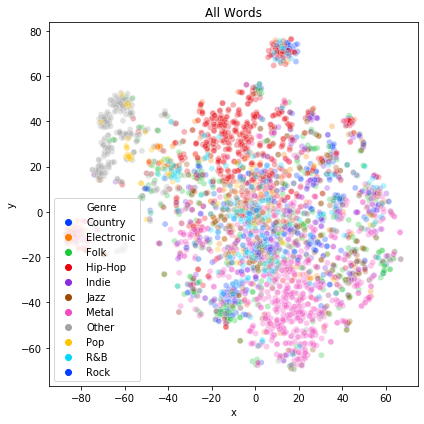

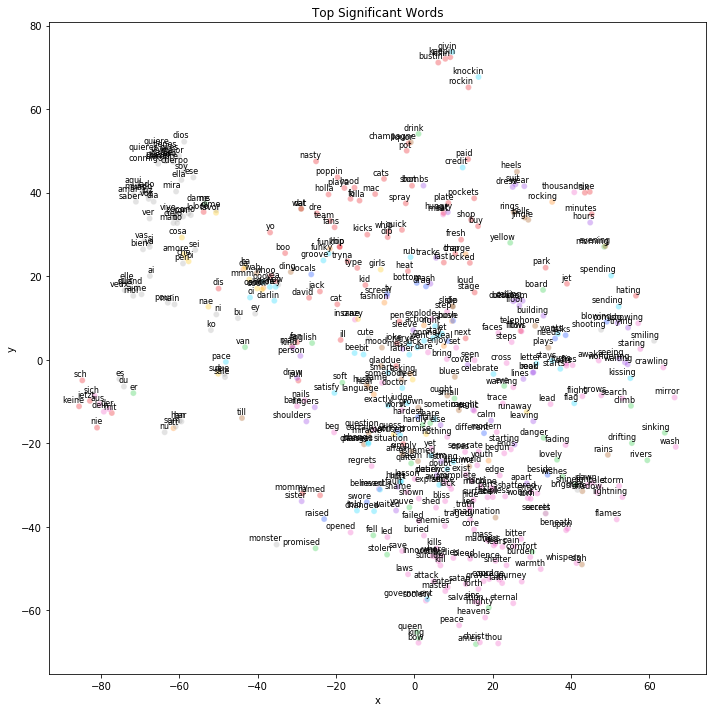

In [44]:
plt.figure(figsize=(15, 15))

COLOR_MAP = 'bright'
MARKER_SIZE = 5
ALPHA = .3

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="x", y="y",
    hue="Genre",
    palette=sns.color_palette(COLOR_MAP, len(set(significant_genre))),
    data=tsne,
    legend='full',
    alpha=ALPHA
)
plt.title('All Words')
plt.tight_layout()


plt.figure(figsize=(10, 10))
ax2 = sns.scatterplot(x="x", y="y",
                      hue="Genre",
                      palette=sns.color_palette(COLOR_MAP, len(set(significant_genre))),
                      data=tsne.iloc[top_words_indices],
                      legend=False,
                      alpha=ALPHA
)
plt.title('Top Significant Words')

for i in top_words_indices:
    plt.annotate(tsne.iloc[i].word,
                 xy=(tsne.iloc[i].x, tsne.iloc[i].y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize=8)

plt.tight_layout()

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, plot_confusion_matrix

In [46]:
def report_results(model, x, y):
    fig, ax = plt.subplots(figsize=(9, 9))
    plot_confusion_matrix(model, x, y,
                          cmap=plt.cm.Blues,
                          normalize='true', ax=ax)

    plt.show()

    print(classification_report(y, model.predict(x)))

In [47]:
%%time

N_FEATURES = 5000

def average_vectors(bow, word_vectors):
    return (bow @ word_vectors) / bow.sum(axis=1)

w2v = Word2Vec.load(os.path.join(MODELS_DIR, 'w2v.model'))
vocab = w2v.wv.index2entity[:N_FEATURES]
embeddings = w2v.wv.vectors[:N_FEATURES]

df = pd.read_pickle(os.path.join(DATA_DIR, 'lyrics_df.pkl'))
df.drop(df[df.genre == 'Not Available'].index, axis=0, inplace=True)

count_vect = CountVectorizer(vocabulary=vocab)
bow = count_vect.fit_transform(df.clean_lyrics.str.join(' '))

# mask to remove songs that none of their lyrics are in the vocabulary
mask = np.asarray(bow.sum(axis=1) > 0).ravel()  

bow_train, bow_test, y_train, y_test = train_test_split(bow[mask], 
                                                        df[mask].genre, 
                                                        test_size=0.2, 
                                                        random_state=42)

CPU times: user 18.7 s, sys: 614 ms, total: 19.3 s
Wall time: 19.3 s


In [48]:
nb_clf = MultinomialNB()
nb_clf.fit(bow_train,y_train);

Show the confusion matrix.

Show the classification report - precision, recall, f1 for each class.

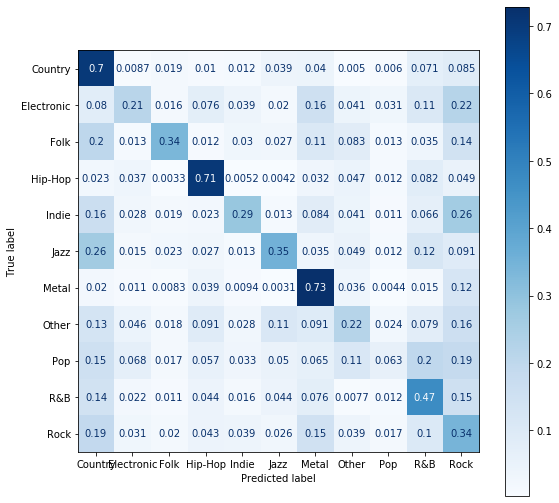

              precision    recall  f1-score   support

     Country       0.24      0.70      0.35     11375
  Electronic       0.17      0.21      0.19      6029
        Folk       0.15      0.34      0.21      1645
     Hip-Hop       0.65      0.71      0.68     19775
       Indie       0.12      0.29      0.17      2467
        Jazz       0.30      0.35      0.32      6277
       Metal       0.43      0.73      0.54     18292
       Other       0.09      0.22      0.13      4204
         Pop       0.47      0.06      0.11     32135
         R&B       0.06      0.47      0.11      2730
        Rock       0.68      0.34      0.46     85546

    accuracy                           0.39    190475
   macro avg       0.30      0.40      0.30    190475
weighted avg       0.53      0.39      0.39    190475



In [49]:
report_results(nb_clf, bow_train, y_train)

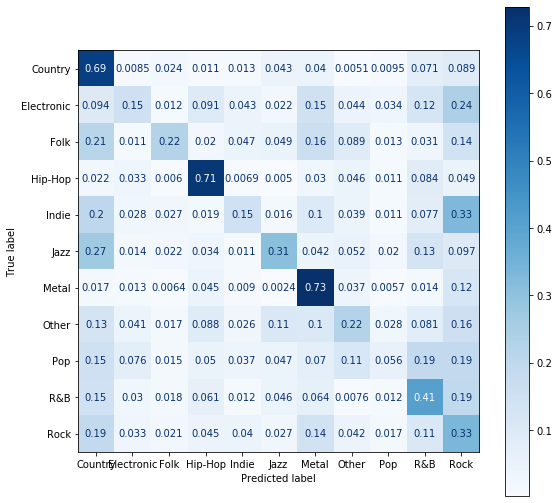

              precision    recall  f1-score   support

     Country       0.24      0.69      0.35      2943
  Electronic       0.12      0.15      0.14      1516
        Folk       0.11      0.22      0.15       447
     Hip-Hop       0.64      0.71      0.67      4959
       Indie       0.06      0.15      0.09       634
        Jazz       0.26      0.31      0.28      1544
       Metal       0.42      0.73      0.54      4536
       Other       0.08      0.22      0.12       956
         Pop       0.43      0.06      0.10      8038
         R&B       0.05      0.41      0.09       659
        Rock       0.66      0.33      0.44     21387

    accuracy                           0.37     47619
   macro avg       0.28      0.36      0.27     47619
weighted avg       0.51      0.37      0.38     47619



In [50]:
report_results(nb_clf, bow_test, y_test)

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [51]:
%%time

X_train = average_vectors(bow_train, embeddings)
X_test = average_vectors(bow_test, embeddings)

CPU times: user 1.76 s, sys: 254 ms, total: 2.02 s
Wall time: 2.01 s


In [52]:
%%time
forest_clf = RandomForestClassifier(max_depth=15, 
                                    class_weight='balanced', 
                                    n_jobs=-1, random_state=42
                                   ).fit(X_train, y_train)


CPU times: user 10min 36s, sys: 262 ms, total: 10min 36s
Wall time: 57 s


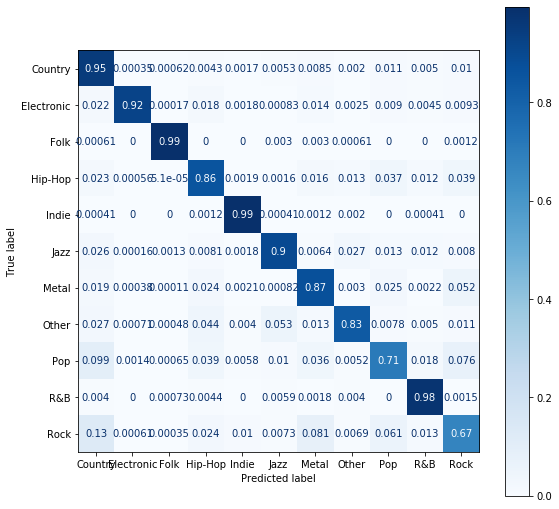

              precision    recall  f1-score   support

     Country       0.42      0.95      0.58     11375
  Electronic       0.98      0.92      0.95      6029
        Folk       0.96      0.99      0.97      1645
     Hip-Hop       0.80      0.86      0.83     19775
       Indie       0.67      0.99      0.80      2467
        Jazz       0.81      0.90      0.85      6277
       Metal       0.65      0.87      0.74     18292
       Other       0.73      0.83      0.78      4204
         Pop       0.77      0.71      0.74     32135
         R&B       0.56      0.98      0.71      2730
        Rock       0.93      0.67      0.78     85546

    accuracy                           0.76    190475
   macro avg       0.75      0.88      0.79    190475
weighted avg       0.82      0.76      0.77    190475



In [53]:
report_results(forest_clf, X_train, y_train)

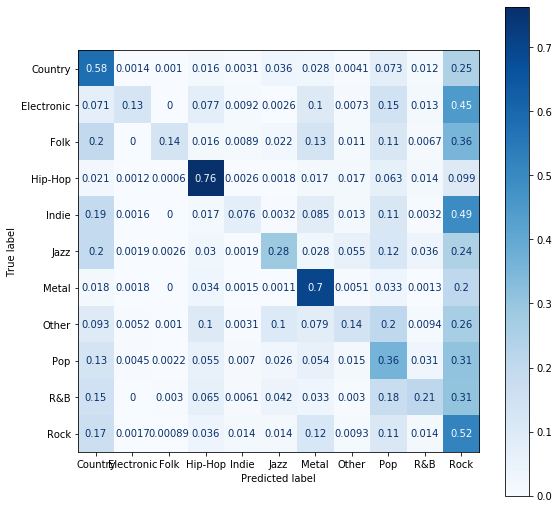

              precision    recall  f1-score   support

     Country       0.23      0.58      0.33      2943
  Electronic       0.66      0.13      0.21      1516
        Folk       0.55      0.14      0.22       447
     Hip-Hop       0.68      0.76      0.72      4959
       Indie       0.11      0.08      0.09       634
        Jazz       0.36      0.28      0.32      1544
       Metal       0.47      0.70      0.57      4536
       Other       0.19      0.14      0.16       956
         Pop       0.43      0.36      0.39      8038
         R&B       0.16      0.21      0.18       659
        Rock       0.63      0.52      0.57     21387

    accuracy                           0.50     47619
   macro avg       0.41      0.35      0.34     47619
weighted avg       0.53      0.50      0.50     47619



In [54]:
report_results(forest_clf, X_test, y_test)

In [55]:
%%time

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

lr_clf = LogisticRegression(C=1, max_iter=100, n_jobs=-1, 
                            class_weight='balanced'
                           ).fit(X_train, y_train)


CPU times: user 1.01 s, sys: 951 ms, total: 1.96 s
Wall time: 41.4 s


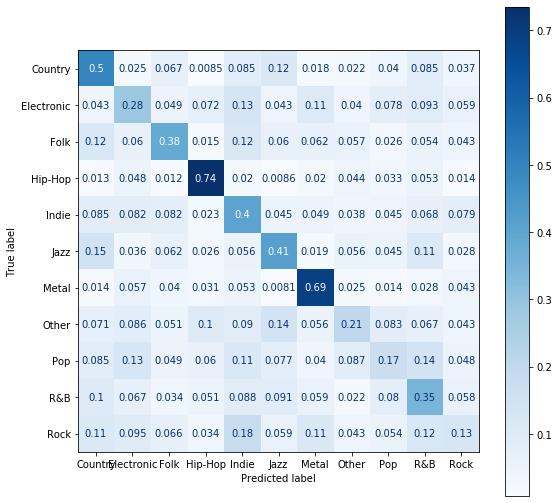

              precision    recall  f1-score   support

     Country       0.28      0.50      0.35     11375
  Electronic       0.10      0.28      0.15      6029
        Folk       0.06      0.38      0.10      1645
     Hip-Hop       0.68      0.74      0.71     19775
       Indie       0.04      0.40      0.07      2467
        Jazz       0.20      0.41      0.27      6277
       Metal       0.49      0.69      0.57     18292
       Other       0.09      0.21      0.13      4204
         Pop       0.43      0.17      0.25     32135
         R&B       0.05      0.35      0.08      2730
        Rock       0.72      0.13      0.21     85546

    accuracy                           0.30    190475
   macro avg       0.29      0.39      0.26    190475
weighted avg       0.54      0.30      0.31    190475



In [56]:
report_results(lr_clf, X_train, y_train)

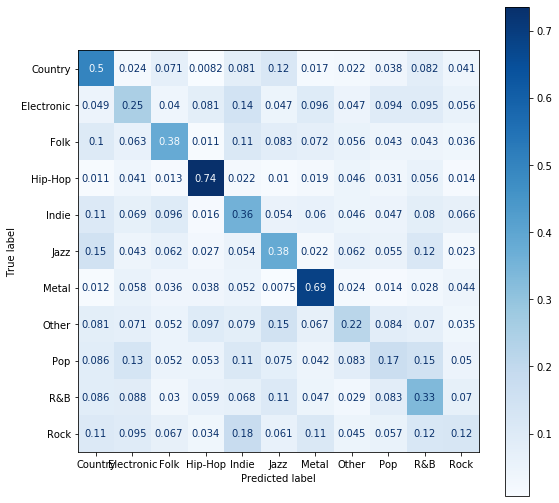

              precision    recall  f1-score   support

     Country       0.29      0.50      0.37      2943
  Electronic       0.09      0.25      0.13      1516
        Folk       0.06      0.38      0.11       447
     Hip-Hop       0.69      0.74      0.71      4959
       Indie       0.04      0.36      0.07       634
        Jazz       0.18      0.38      0.25      1544
       Metal       0.49      0.69      0.57      4536
       Other       0.08      0.22      0.12       956
         Pop       0.41      0.17      0.24      8038
         R&B       0.04      0.33      0.08       659
        Rock       0.71      0.12      0.21     21387

    accuracy                           0.29     47619
   macro avg       0.28      0.38      0.26     47619
weighted avg       0.54      0.29      0.30     47619



In [57]:
report_results(lr_clf, X_test, y_test)

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [58]:
%%time

tfidf = TfidfTransformer()

X_train = tfidf.fit_transform(bow_train)
X_test = tfidf.transform(bow_test)

X_train = average_vectors(X_train, embeddings)
X_test = average_vectors(X_test, embeddings)


CPU times: user 1.83 s, sys: 273 ms, total: 2.1 s
Wall time: 2.1 s


In [59]:
%%time
forest_clf = RandomForestClassifier(max_depth=15, 
                                    class_weight='balanced', 
                                    n_jobs=-1, random_state=42
                                   ).fit(X_train, y_train)


CPU times: user 10min 30s, sys: 222 ms, total: 10min 30s
Wall time: 56.4 s


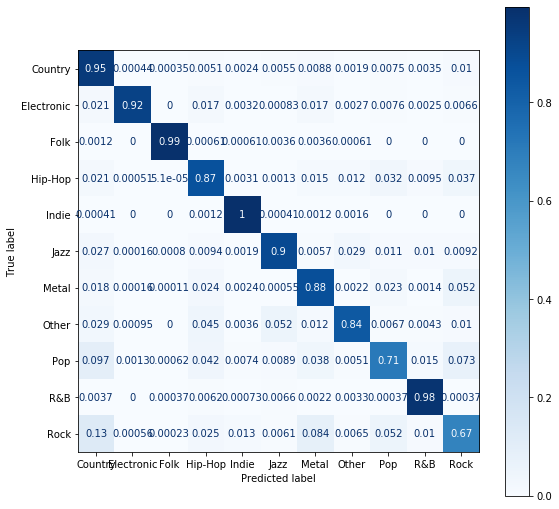

              precision    recall  f1-score   support

     Country       0.42      0.95      0.58     11375
  Electronic       0.98      0.92      0.95      6029
        Folk       0.97      0.99      0.98      1645
     Hip-Hop       0.80      0.87      0.83     19775
       Indie       0.62      1.00      0.76      2467
        Jazz       0.83      0.90      0.86      6277
       Metal       0.64      0.88      0.74     18292
       Other       0.74      0.84      0.79      4204
         Pop       0.80      0.71      0.75     32135
         R&B       0.61      0.98      0.75      2730
        Rock       0.93      0.67      0.78     85546

    accuracy                           0.77    190475
   macro avg       0.76      0.88      0.80    190475
weighted avg       0.82      0.77      0.78    190475



In [60]:
report_results(forest_clf, X_train, y_train)

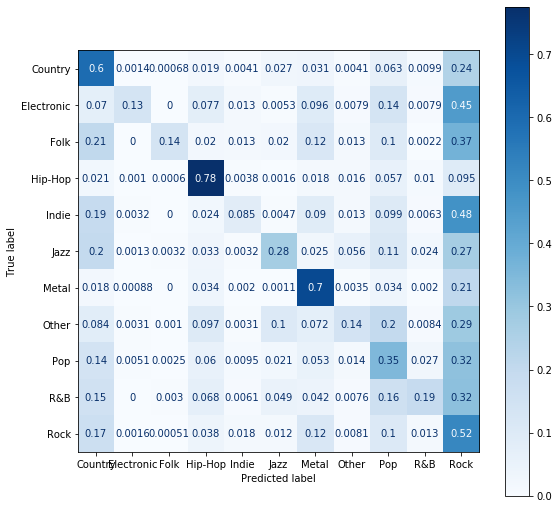

              precision    recall  f1-score   support

     Country       0.23      0.60      0.34      2943
  Electronic       0.68      0.13      0.22      1516
        Folk       0.58      0.14      0.22       447
     Hip-Hop       0.68      0.78      0.72      4959
       Indie       0.09      0.09      0.09       634
        Jazz       0.39      0.28      0.32      1544
       Metal       0.47      0.70      0.56      4536
       Other       0.21      0.14      0.17       956
         Pop       0.44      0.35      0.39      8038
         R&B       0.16      0.19      0.18       659
        Rock       0.62      0.52      0.56     21387

    accuracy                           0.50     47619
   macro avg       0.41      0.35      0.34     47619
weighted avg       0.53      0.50      0.50     47619



In [61]:
report_results(forest_clf, X_test, y_test)

In [62]:
%%time

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

lr_clf = LogisticRegression(C=1, max_iter=100, n_jobs=-1, 
                            class_weight='balanced').fit(X_train, y_train)


CPU times: user 883 ms, sys: 238 ms, total: 1.12 s
Wall time: 40.9 s


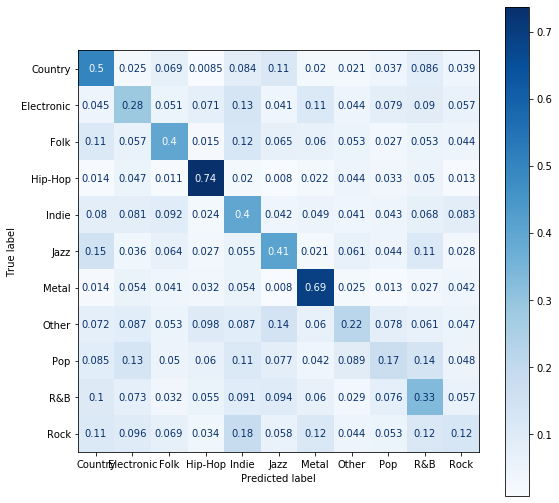

              precision    recall  f1-score   support

     Country       0.28      0.50      0.36     11375
  Electronic       0.10      0.28      0.15      6029
        Folk       0.06      0.40      0.10      1645
     Hip-Hop       0.68      0.74      0.71     19775
       Indie       0.04      0.40      0.07      2467
        Jazz       0.20      0.41      0.27      6277
       Metal       0.49      0.69      0.57     18292
       Other       0.09      0.22      0.13      4204
         Pop       0.43      0.17      0.25     32135
         R&B       0.05      0.33      0.08      2730
        Rock       0.72      0.12      0.21     85546

    accuracy                           0.30    190475
   macro avg       0.28      0.39      0.26    190475
weighted avg       0.54      0.30      0.31    190475



In [63]:
report_results(lr_clf, X_train, y_train)

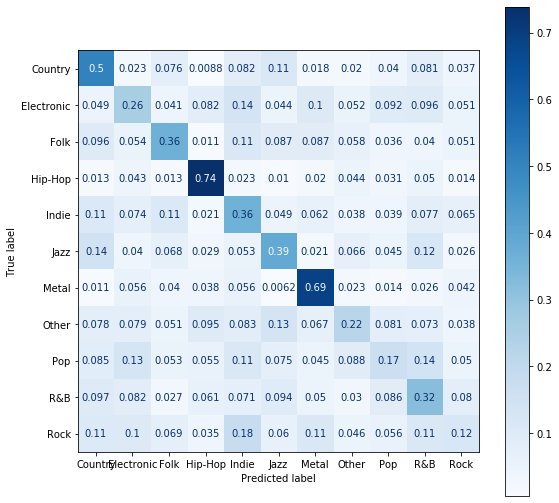

              precision    recall  f1-score   support

     Country       0.29      0.50      0.37      2943
  Electronic       0.09      0.26      0.13      1516
        Folk       0.06      0.36      0.10       447
     Hip-Hop       0.68      0.74      0.71      4959
       Indie       0.04      0.36      0.07       634
        Jazz       0.19      0.39      0.25      1544
       Metal       0.48      0.69      0.57      4536
       Other       0.08      0.22      0.12       956
         Pop       0.41      0.17      0.24      8038
         R&B       0.04      0.32      0.08       659
        Rock       0.71      0.12      0.20     21387

    accuracy                           0.29     47619
   macro avg       0.28      0.38      0.26     47619
weighted avg       0.53      0.29      0.30     47619



In [64]:
report_results(lr_clf, X_test, y_test)

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.